Reference: [arima and sarima](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/Discussions/time_series_forecasting/Time_series_forecasting_ARIMAvsSARIMA.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv')
print(df1.shape)
df1.head(20).T

(100, 1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
x,88,84,85,85,84,85,83,85,88,89,91,99,104,112,126,138,146,151,150,148


In [3]:
def usudiff_and_seasdiff(data, seas_dei, size, sup_tit):
    fig, axes = plt.subplots(2, 1, figsize = size, dpi = 80, sharex=True)

    # Usual Differencing
    axes[0].plot(data[:], label='Original Series', color = 'darkblue')
    axes[0].plot(data[:].diff(1), label='Usual Differencing (d = 1)', color = 'orange')
    axes[0].set_title('Usual Differencing')
    axes[0].legend(loc='upper left', fontsize=10)


    # Seasinal Dei
    axes[1].plot(data[:], label='Original Series')
    axes[1].plot(data[:].diff(seas_dei), label='Seasonal Differencing', color='red')
    axes[1].set_title('Seasonal Differencing (d = %d)'%seas_dei)
    axes[1].legend(loc='upper left', fontsize=10)
    sup_tit = '%s %s %s'%(20*'=', sup_tit, 20*'=')
    plt.suptitle(sup_tit, fontsize=12)

In this dataset, we firstly assume that the `seasonality` is 12 months of a year! So, we set `seas_dei = 12`

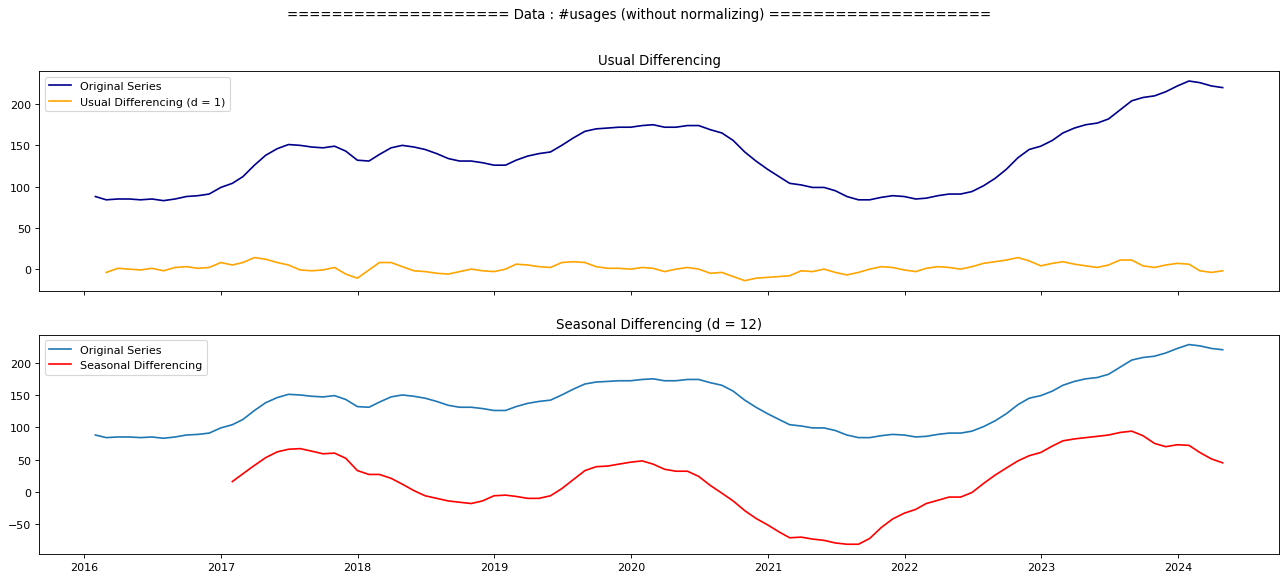

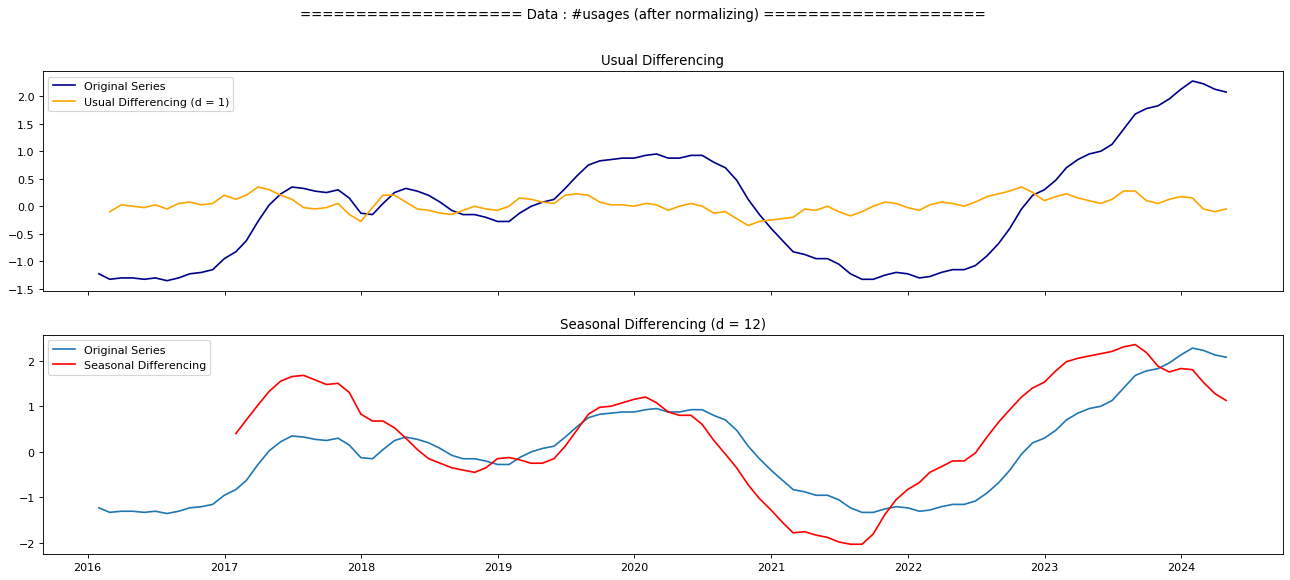

In [4]:
df1 = df1.set_index(pd.date_range('01/01/2016', periods = 100, freq = 'M'))
df1_norm = df1.apply(lambda x : round(((x - df1.mean()) / df1.std()) , 3), axis = 1)
usudiff_and_seasdiff(df1, 12, (20, 8), 'Data : #usages (without normalizing)')
usudiff_and_seasdiff(df1_norm, 12, (20, 8), 'Data : #usages (after normalizing)')

Look at the `2nd` and the `4th graphs`, **adding `seasonal term` will be better than non-using**; compared to the 1st and 3rd graphs!

Moreover, `normalizied` dataset will reduce the loss better! For instance, in the 1st and the 3rd panels, ***the distance between the `original` and `usual diff`*** after nomalizing is **`more narrow than`** non-using; also in the 2nd and 4th panels!

### Establish `SARIMAX model`

In [5]:
import pmdarima as pm
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose

def train_model_and_split(data, train_rate, target_name, msc = -24):
    # multiplicative seasonal component
    result_mul = seasonal_decompose(data[target_name][msc:])

    seasonal_index = result_mul.seasonal[-12:].to_frame()
    seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
    # merge with the base data
    data['month'] = data.index.month
    df = pd.merge(data, seasonal_index, how='left', on='month')
    df.columns = [target_name, 'month', 'seasonal_index']
    df.index = data.index  # reassign the index.
    train_size = int(train_rate*len(data))
    df_train = df[: train_size]
    df_test = df[train_size :]
    return df_train, df_test, seasonal_index
    
df_train, df_test, seasonal_index = train_model_and_split(df1_norm, 0.84, 'x')

In [6]:
sxmodel = pm.auto_arima(df_train[['x']], exogenous=df_train[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=-125.671, BIC=-112.095, Time=1.414 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=-15.602, BIC=-8.814, Time=0.124 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=-101.153, BIC=-89.840, Time=0.591 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=-96.957, BIC=-85.644, Time=1.035 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=-17.190, BIC=-12.665, Time=0.070 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=-104.789, BIC=-93.476, Time=0.202 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=-123.900, BIC=-108.061, Time=1.944 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  68.835
Date:                            Fri, 14 Aug 2020   AIC                           -125.671
Time:                                    16:37:43   BIC                           -112.095
Sample:                                01-31-2016   HQIC                          -120.272
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0020      0.007      0.306      0.759      -0.011       0.015
seasonal_index  7.271e-09   3.42e-09      2.127      0.033     5.7e-10     1.4e-08
ar.L1              0.6903      0.105      6.579      0.000       0.485       0.896
ma.L1              0.4996      0.121      4.132      0.000       0.263       0.737
ma.S.L12          -0.9666      1.681     -0.575      0.565      -4.261       2.328
sigma2             0.0061      0.010      0.622      0.534      -0.013       0.026
===================================================================================
Ljung-Box (Q):                       46.10   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.23   Prob(JB):                         0.98
Heteroskedasticity (H):               0.90   Skew:                             0.05
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+20. Standard errors may be unstable.
"""

In [7]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)                        # ME
    mae = np.mean(np.abs(forecast - actual))               # MAE
    rmse = np.mean((forecast - actual)**2)**.5             # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]              # corr
    acf1 = acf(forecast - actual, fft = False)[1]          # ACF1
    print('ME = %s \nMAE = %s \nRMSE = %s \ncorr = %s \nacf1 = %s'
          %(me, mae, rmse, corr, acf1))

In [8]:
def forecast_and_eval(train_model, target_name, n_periods, data_train, data_test, title):
    test_size = len(data_test)
    fitted, confint = train_model.predict(n_periods=n_periods, 
                                          exogenous=np.tile(seasonal_index.values, 2).reshape(-1,1), 
                                          return_conf_int=True) 
    index_of_fc = pd.date_range(data_train.index[-1], periods = n_periods, freq='MS')
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    # linked-data-point-in-line from the_end_of_train_set to pred and test_set
    data_true = pd.concat([data_train[-1:], data_test])
    data_pred = pd.concat([data_train[target_name][-1:], fitted_series]) 
   
    # Plot
    plt.figure(figsize = (16, 7))
    plt.subplot(211)
    plt.plot(data_pred[: test_size+1], color='darkgreen', label = 'forecast')
    plt.plot(data_train[target_name], label = 'train model')
    plt.plot(data_true[target_name], label = 'true / actual')
    plt.fill_between(lower_series.index[:test_size], 
                     lower_series[:test_size], 
                     upper_series[:test_size],
                     color='k', alpha=.15)
    plt.title(title)
    plt.legend()
    forecast_accuracy(fitted_series[:test_size].values, data_test[target_name].values)
    
    plt.subplot(212)
    
    plt.plot(data_pred, color='darkgreen', label = 'forecast')
    plt.plot(data_train[target_name], label = 'train model')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series,
                     color='k', alpha=.15)
    plt.title('Forecasting_model in the next %d years, from %s'%(n_periods // 12, index_of_fc[0]))
    plt.legend()
    plt.show()

ME = -0.09822071621280831 
MAE = 0.1395057099966392 
RMSE = 0.17241206191788466 
corr = 0.9766643318530978 
acf1 = 0.7470745957119465


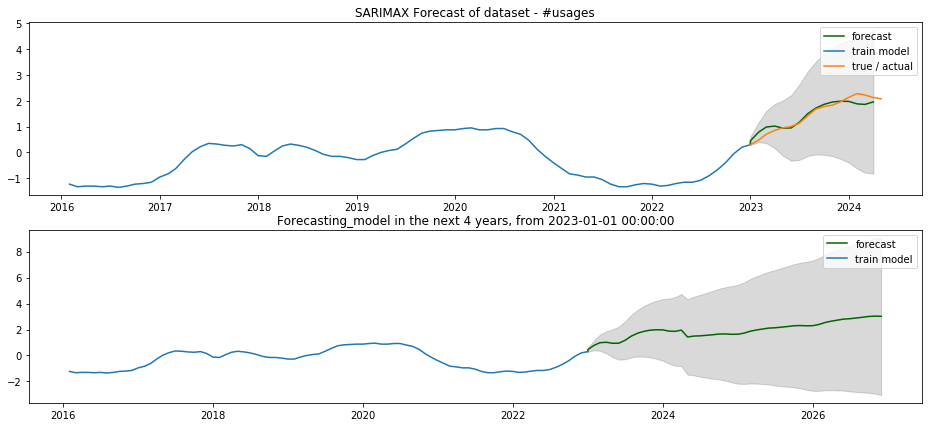

In [9]:
forecast_and_eval(sxmodel, 'x', 48, df_train, df_test, "SARIMAX Forecast of dataset - #usages")

## Example 2.

In [10]:
df2 = pd.read_csv(r"D:\Nhan\Data\AirPassengers.csv", parse_dates=['Month'], index_col='Month')
print(df2.shape)
df2.head()

(144, 1)


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


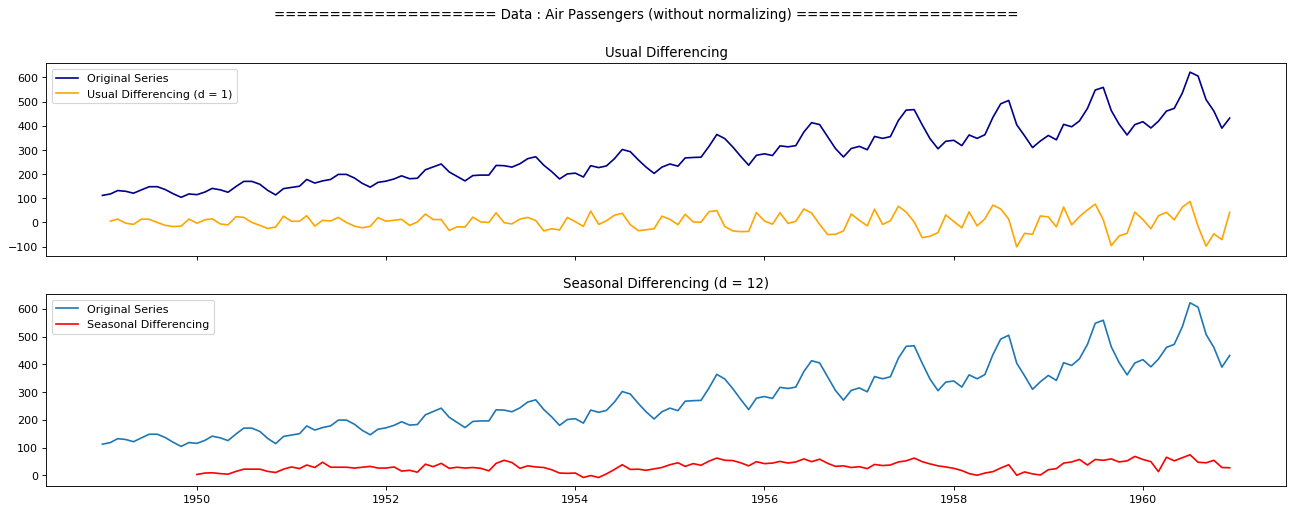

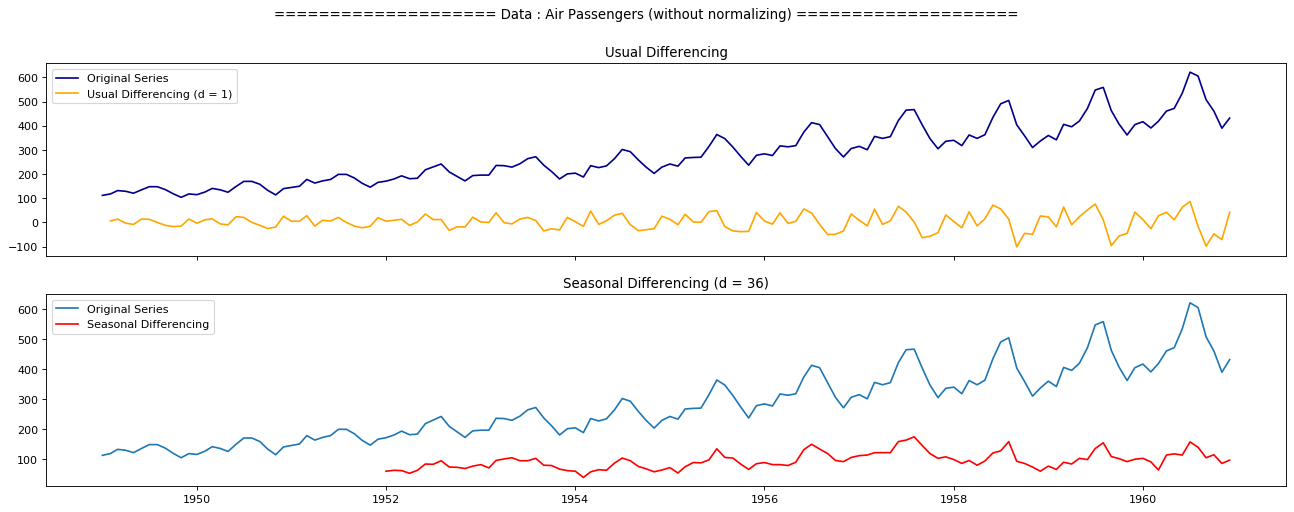

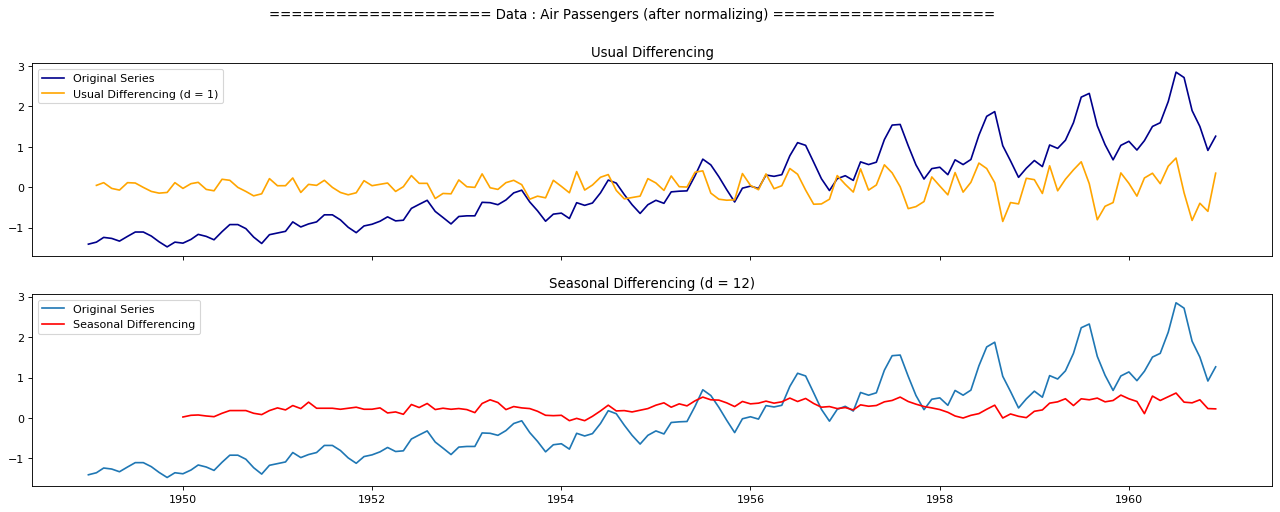

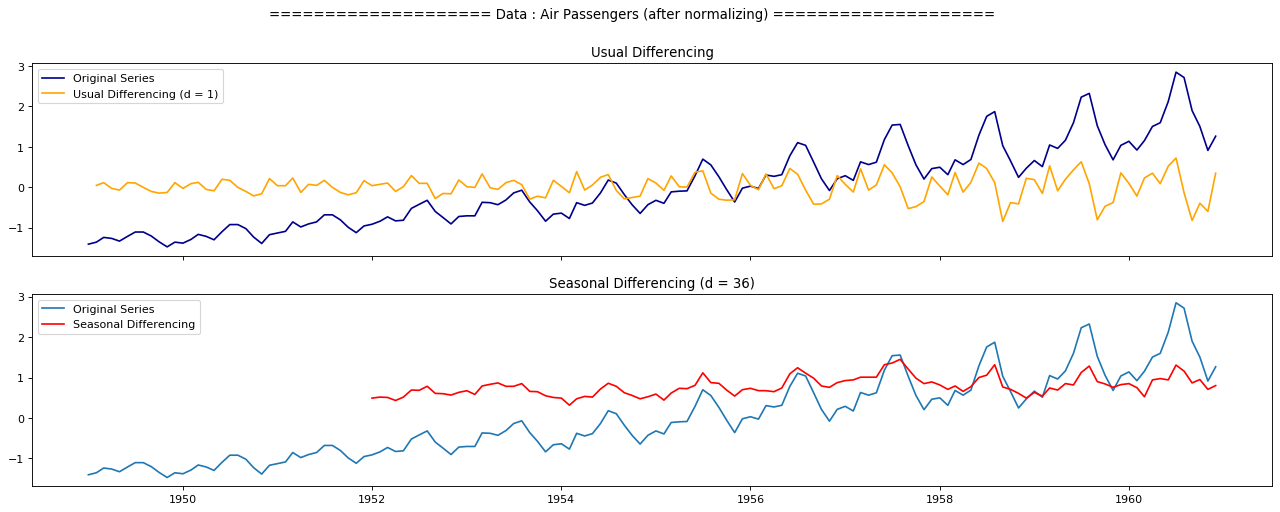

In [11]:
df2_norm = df2.apply(lambda x : round(((x - df2.mean()) / df2.std()) , 3), axis = 1)
usudiff_and_seasdiff(df2, 12, (20, 7), 'Data : Air Passengers (without normalizing)')
usudiff_and_seasdiff(df2, 36, (20, 7), 'Data : Air Passengers (without normalizing)')
usudiff_and_seasdiff(df2_norm, 12, (20, 7), 'Data : Air Passengers (after normalizing)')
usudiff_and_seasdiff(df2_norm, 36, (20, 7), 'Data : Air Passengers (after normalizing)')

In [12]:
df_train, df_test,seasonal_index = train_model_and_split(df2_norm, 0.84, '#Passengers', 36)
sxmodel = pm.auto_arima(df_train[['#Passengers']], exogenous=df_train[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=36,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,36) [intercept=True]; AIC=-85.948, BIC=-71.363, Time=3.818 seconds
Fit ARIMA(0,0,0)x(0,1,0,36) [intercept=True]; AIC=-1.652, BIC=5.641, Time=0.318 seconds
Fit ARIMA(1,0,0)x(1,1,0,36) [intercept=True]; AIC=-87.360, BIC=-75.205, Time=4.433 seconds
Fit ARIMA(0,0,1)x(0,1,1,36) [intercept=True]; AIC=-55.934, BIC=-43.780, Time=6.211 seconds
Fit ARIMA(0,0,0)x(0,1,0,36) [intercept=False]; AIC=204.420, BIC=209.282, Time=0.721 seconds
Fit ARIMA(1,0,0)x(0,1,0,36) [intercept=True]; AIC=-88.695, BIC=-78.972, Time=0.745 seconds
Fit ARIMA(1,0,0)x(0,1,1,36) [intercept=True]; AIC=-87.198, BIC=-75.044, Time=8.864 seconds
Fit ARIMA(1,0,0)x(1,1,1,36) [intercept=True]; AIC=-87.248, BIC=-72.663, Time=11.711 seconds
Near non-invertible roots for order (1, 0, 0)(1, 1, 1, 36); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(2,0,0)x(0,1,0,36) [intercept=True]; AIC=-88.266, BIC=-76.112,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 36)   Log Likelihood                  48.348
Date:                            Fri, 14 Aug 2020   AIC                            -88.695
Time:                                    16:38:31   BIC                            -78.972
Sample:                                01-01-1949   HQIC                           -84.786
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1366      0.052      2.639      0.008       0.035       0.238
seasonal_index -5.552e-09   8.04e-11    -69.026      0.000   -5.71e-09   -5.39e-09
ar.L1              0.8148      0.056     14.541      0.000       0.705       0.925
sigma2             0.0183      0.002      7.582      0.000       0.014       0.023
===================================================================================
Ljung-Box (Q):                      103.68   Jarque-Bera (JB):                 4.21
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               2.80   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+22. Standard errors may be unstable.
"""

ME = -0.02884961330332547 
MAE = 0.11555961151404949 
RMSE = 0.13246283894123512 
corr = 0.9804013812319018 
acf1 = 0.8293307218931041


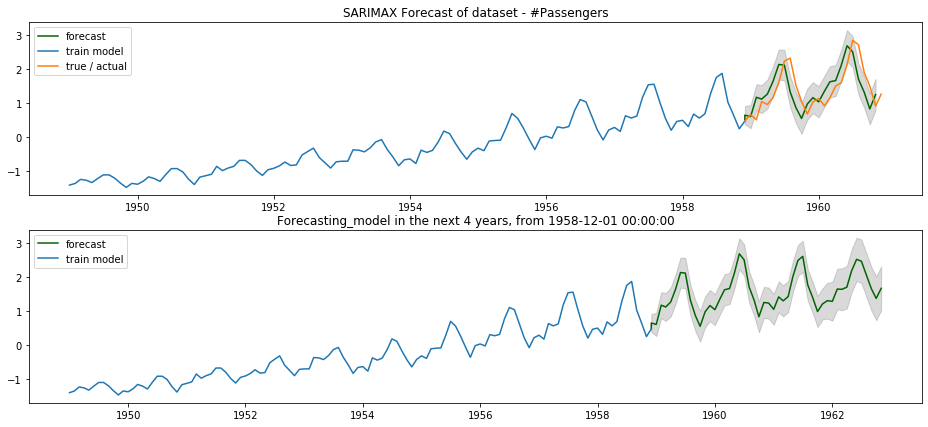

In [13]:
forecast_and_eval(sxmodel, '#Passengers', 48, df_train, df_test, "SARIMAX Forecast of dataset - #Passengers")

## Example 3.

In [14]:
df3 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', 
                  parse_dates=['date'], index_col='date')
print(df3.shape)
df3.head()

(204, 1)


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


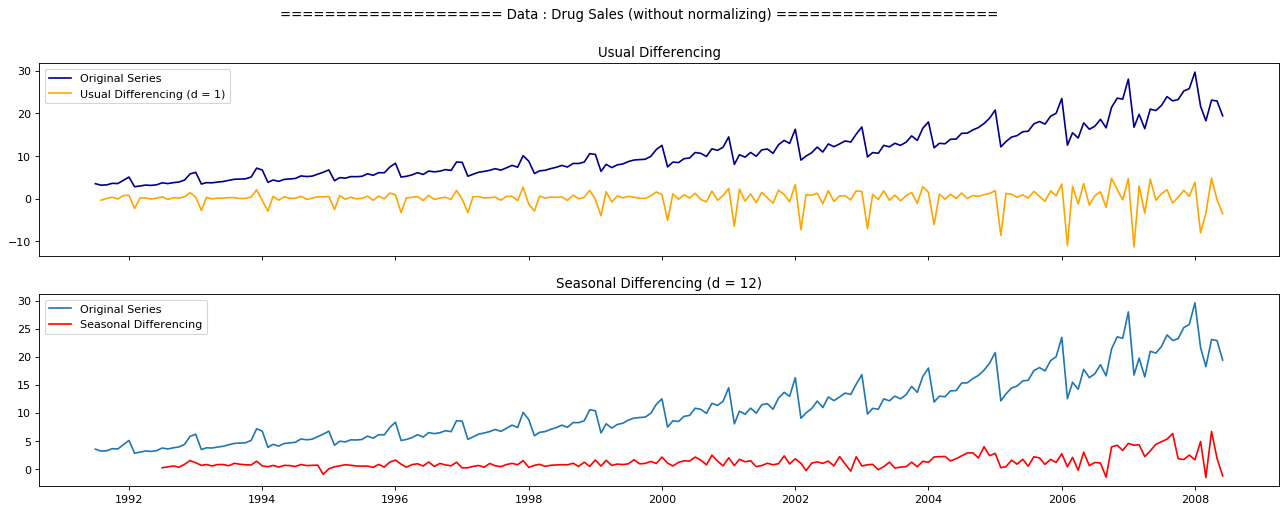

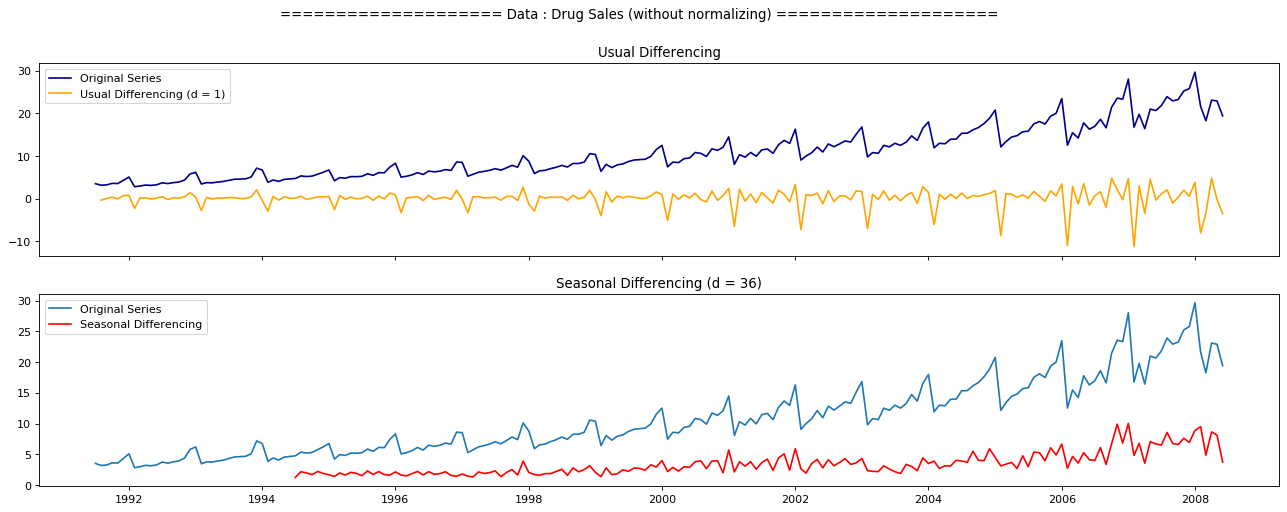

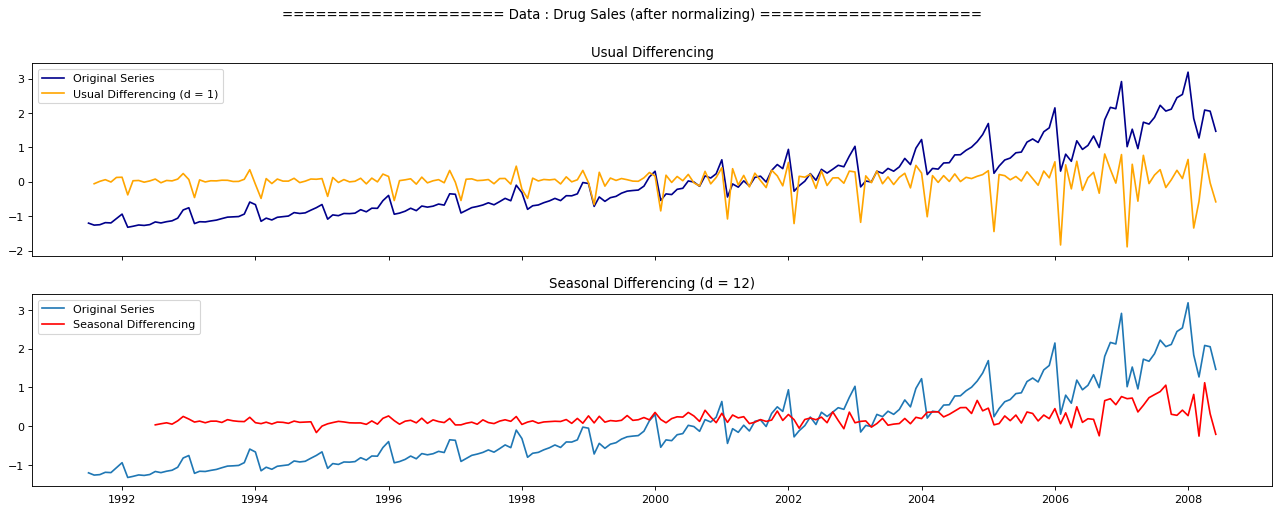

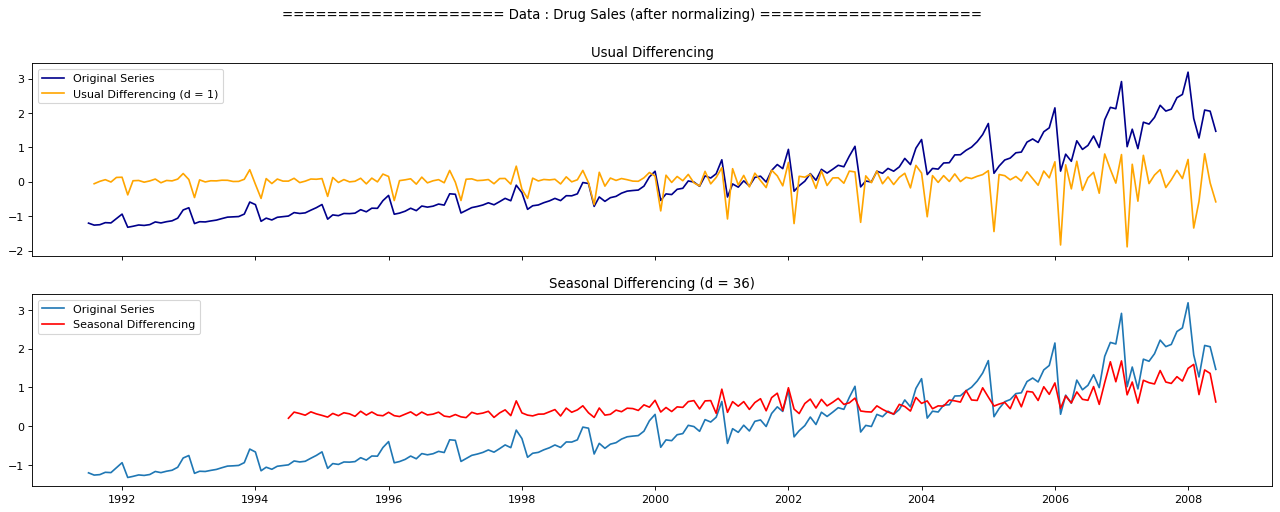

In [15]:
df3_norm = df3.apply(lambda x : round(((x - df3.mean()) / df3.std()) , 3), axis = 1)
usudiff_and_seasdiff(df3, 12, (20, 7), 'Data : Drug Sales (without normalizing)')
usudiff_and_seasdiff(df3, 36, (20, 7), 'Data : Drug Sales (without normalizing)')
usudiff_and_seasdiff(df3_norm, 12, (20, 7), 'Data : Drug Sales (after normalizing)')
usudiff_and_seasdiff(df3_norm, 36, (20, 7), 'Data : Drug Sales (after normalizing)')

In [16]:
df_train, df_test,seasonal_index = train_model_and_split(df3_norm, 0.8, 'value', 36)
sxmodel = pm.auto_arima(df_train[['value']], exogenous=df_train[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=36,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,36) [intercept=True]; AIC=-149.823, BIC=-132.758, Time=21.265 seconds
Fit ARIMA(0,0,0)x(0,1,0,36) [intercept=True]; AIC=-75.122, BIC=-66.590, Time=0.635 seconds
Fit ARIMA(1,0,0)x(1,1,0,36) [intercept=True]; AIC=-107.695, BIC=-93.474, Time=6.990 seconds
Fit ARIMA(0,0,1)x(0,1,1,36) [intercept=True]; AIC=-88.308, BIC=-74.087, Time=5.725 seconds
Fit ARIMA(0,0,0)x(0,1,0,36) [intercept=False]; AIC=181.216, BIC=186.904, Time=0.348 seconds
Fit ARIMA(1,0,1)x(0,1,0,36) [intercept=True]; AIC=-146.725, BIC=-132.504, Time=5.512 seconds
Fit ARIMA(1,0,1)x(1,1,1,36) [intercept=True]; AIC=-144.008, BIC=-124.098, Time=23.096 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 36); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,0,1)x(0,1,2,36) [intercept=True]; AIC=-151.191, BIC=-131.282, Time=42.464 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 2, 36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  163
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 36)   Log Likelihood                  88.448
Date:                            Fri, 14 Aug 2020   AIC                           -160.895
Time:                                    16:49:24   BIC                           -138.142
Sample:                                07-01-1991   HQIC                          -151.651
                                     - 01-01-2005                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0283      0.030      0.936      0.349      -0.031       0.087
seasonal_index -4.476e-08   7.22e-09     -6.197      0.000   -5.89e-08   -3.06e-08
ar.L1              0.0784      0.062      1.270      0.204      -0.043       0.199
ar.L2              0.3888      0.056      6.961      0.000       0.279       0.498
ar.L3              0.4581      0.072      6.373      0.000       0.317       0.599
ar.S.L36          -0.0760      0.104     -0.734      0.463      -0.279       0.127
ar.S.L72           0.2921      0.159      1.834      0.067      -0.020       0.604
sigma2             0.0136      0.002      8.053      0.000       0.010       0.017
===================================================================================
Ljung-Box (Q):                       87.79   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               4.77   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+17. Standard errors may be unstable.
"""

ME = -0.04261349703817089 
MAE = 0.1212976219141013 
RMSE = 0.14331794468513007 
corr = 0.9831331065751653 
acf1 = 0.8691758669067013


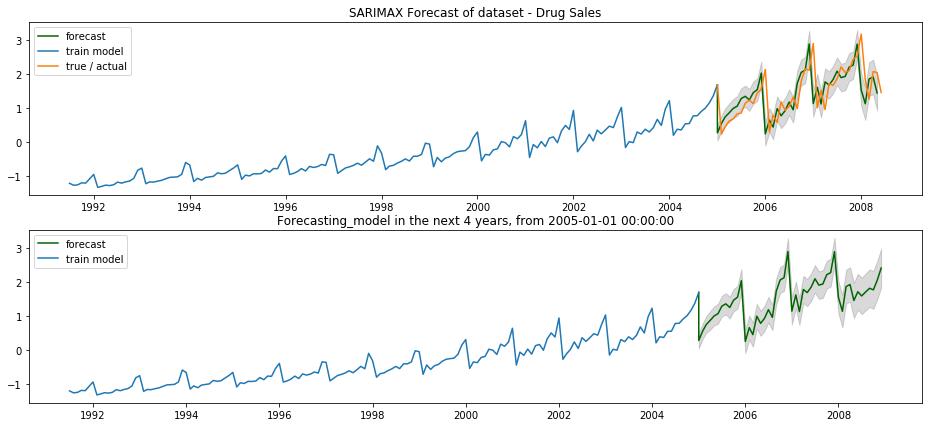

In [17]:
forecast_and_eval(sxmodel, 'value', 48, df_train, df_test, "SARIMAX Forecast of dataset - Drug Sales")